In [1]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture
from photutils import centroids
#%matplotlib inline

plt.style.use(r"C:\Users\Sam Whitebook\Documents\GitHub\LocalTestRepository\Phys240.mplstyle")

In [2]:
# files = sorted(glob.glob("F:/SDI/sec17/*.fz"))
#files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/sec31small/*"))

files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\TRIPP_Test\*"))

print(len(files))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
try:
    aligned = [aa.register(i, data[0])[0] for i in data[0:]]
except:
    aligned = data
    print("DID NOT ALIGN")
template = np.mean(aligned, axis = 0)
bkg_phot = sep.Background(template)
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image

w = WCS(hdus[0][1].header) #WCS matrix object

11


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


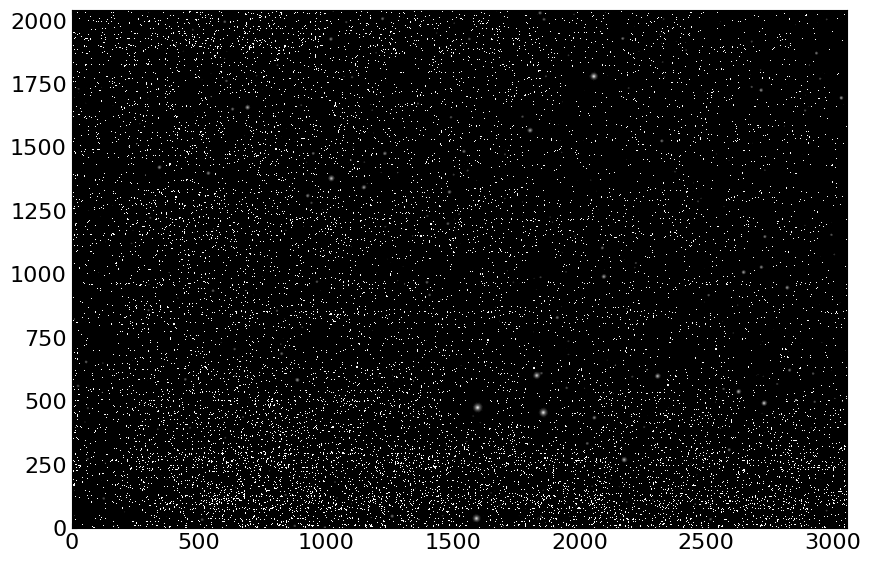

In [3]:
plt.figure()
plt.imshow(template, cmap='gray', norm=LogNorm(np.percentile(template, 90), np.percentile(template, 100)), origin="lower")
plt.show()

In [4]:
#~~~~~ g band
references = []
mags = []
for src in extracted_phot: #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs')
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_g', 'psfMagErr_g'], radius = 15 * u.arcsec, region = False)
    if search: #if SDSS query returned results, continue
        if search['psfMag_g'] < 16 and search['type'] == 'STAR':
            ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], g_mag = search['psfMag_g'], g_mag_err = search['psfMagErr_g'])
            references.append(ref)

for ref in references:
        coords = [ref['x_coord'], ref['y_coord']]
        radius = ( (ref['x_max'] - ref['x_min']) / 2 )
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(template - bkg_phot.back(), app)
        inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum']))
        mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['g_mag']), sky_err = float(ref['g_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
        mags.append(mag_cat)

# #~~~~~ i band
# references = []
# mags = []
# for src in extracted_phot: #indexes extracted sources by try number to find reference stars
#     x = src['x']
#     y = src['y']
#     coord = pixel_to_skycoord(x, y, w).transform_to('icrs')
#     search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_i', 'psfMagErr_i'], radius = 15 * u.arcsec, region = False)
#     if search: #if SDSS query returned results, continue
#         if search['psfMag_i'] < 16 and search['type'] == 'STAR':
#             print("hi")
#             ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], i_mag = search['psfMag_i'], i_mag_err = search['psfMagErr_i'])
#             references.append(ref)

# for ref in references:
#     coords = [ref['x_coord'], ref['y_coord']]
#     radius = ( (ref['x_max'] - ref['x_min']) / 2 )
#     app = CircularAperture(coords, radius) # takes instrumental mag at point
#     app_phot = aperture_photometry(template - bkg_phot.back(), app)
#     inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum']))
#     mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['i_mag']), sky_err = float(ref['i_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
#     mags.append(mag_cat)

In [5]:
print(mags)
print(references)

[{'inst_mag': -9.291204183474774, 'inst_err': None, 'sky_mag': 13.38843, 'sky_err': 0.0006998759}, {'inst_mag': -8.785079798001641, 'inst_err': None, 'sky_mag': 14.64169, 'sky_err': 0.01780463}, {'inst_mag': -9.047125363762387, 'inst_err': None, 'sky_mag': 14.46374, 'sky_err': 0.01780101}, {'inst_mag': -9.761886554369374, 'inst_err': None, 'sky_mag': 13.86022, 'sky_err': 0.0006800483}, {'inst_mag': -13.132320659428373, 'inst_err': None, 'sky_mag': 10.91893, 'sky_err': 0.0001627471}, {'inst_mag': -7.9516861010398525, 'inst_err': None, 'sky_mag': 15.33716, 'sky_err': 0.01367101}, {'inst_mag': -8.613072819464248, 'inst_err': None, 'sky_mag': 14.76482, 'sky_err': 0.01463938}, {'inst_mag': -7.128311552569527, 'inst_err': None, 'sky_mag': 15.91435, 'sky_err': 0.01785904}, {'inst_mag': -8.4476403432055, 'inst_err': None, 'sky_mag': 14.89002, 'sky_err': 0.01781085}, {'inst_mag': -7.34328332913595, 'inst_err': None, 'sky_mag': 15.72693, 'sky_err': 0.01369773}, {'inst_mag': -6.843852484617118, '

In [11]:
from scipy.optimize import minimize

0.8173413434003488
21.784536449869748
first try: [ 0.58849073 19.92865192]
second try: [ 0.81734136 21.78453664]
The chi squared per dof for unity is 2.5880494191062406
The chi squared per dof for a line is 0.056527294906931015


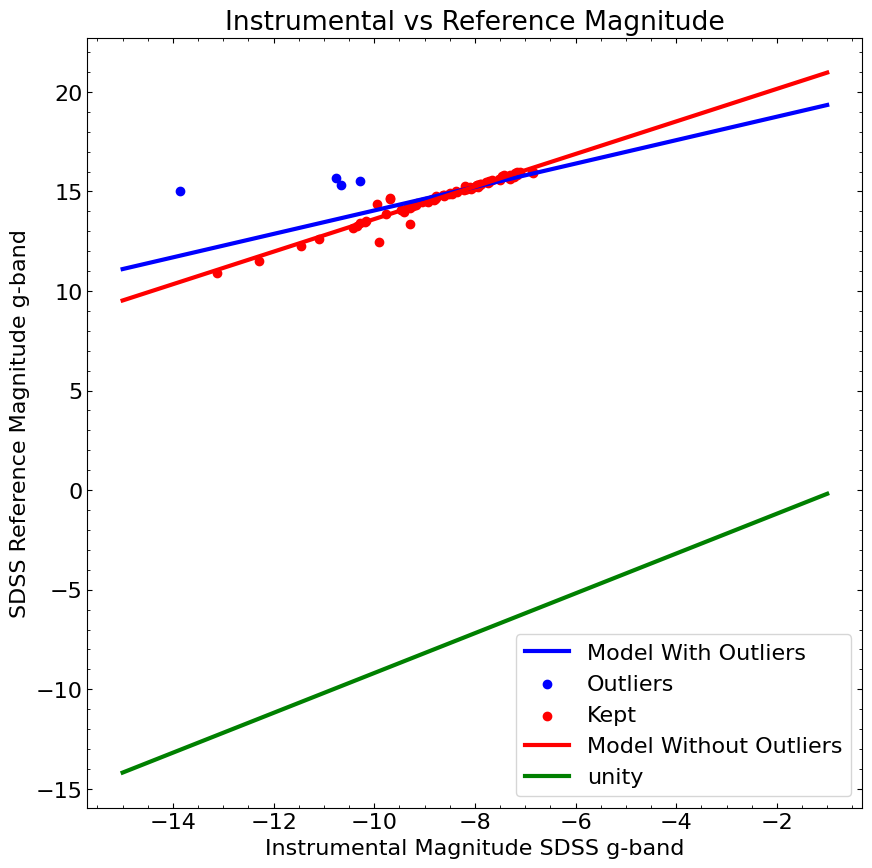

In [21]:
inst_mags = [mag['inst_mag'] for mag in mags]
sky_mags = [mag['sky_mag'] for mag in mags]
res = []


#Makes linear model for calibration:
p0 = np.polyfit(inst_mags, sky_mags, deg = 1)
x = np.arange(-15, 0)
y = p0[0]*x + p0[1]
plt.plot(x, y, color = 'b', label = "Model With Outliers")
diffs = [s['sky_mag']- (s['inst_mag']*p0[0] + p0[1]) for s in mags]
stdv = np.std(diffs)

inst_mags_final = []
sky_mags_final = []
outlier_inst =[]
outlier_sky =[]

for diff in diffs:
    if diff < stdv:
        i = diffs.index(diff)
        inst_mags_final.append(inst_mags[i])
        sky_mags_final.append(sky_mags[i])
    else:
        i = diffs.index(diff)
        outlier_inst.append(inst_mags[i])
        outlier_sky.append(sky_mags[i])

inst_mags_final = np.array(inst_mags_final)
sky_mags_final = np.array(sky_mags_final)
p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1)

#~~~ Demand a slope of unity
def unity(param, x):
    return x + param

def line(params, x):
    return params[0]*x + params[1]

def chi_sq(params, func, x, y):
    return np.sum((func(params, x) - y)**2)

#Unity
res = minimize(chi_sq, 20, args=(unity, inst_mags_final, sky_mags_final))
zp = res.x[0]

#Line
res = minimize(chi_sq, [1, 20], args=(line, inst_mags_final, sky_mags_final))
slope, zp = res.x

print(slope)
print(zp)

print("first try: {}".format(p0))
print("second try: {}".format(p1))

print("The chi squared per dof for unity is", chi_sq(zp, unity, inst_mags_final, sky_mags_final)/(len(inst_mags_final) - 1))
print("The chi squared per dof for a line is", chi_sq([slope, zp], line, inst_mags_final, sky_mags_final)/(len(inst_mags_final) - 2))

plt.scatter(outlier_inst, outlier_sky, color = 'b', label = "Outliers")
plt.scatter(inst_mags_final, sky_mags_final, color = 'r', label = "Kept")
plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers")
plt.plot(x, [i + res.x[0] for i in x], color = 'g', label = "unity")
plt.xlabel("Instrumental Magnitude SDSS g-band")
plt.ylabel("SDSS Reference Magnitude g-band")
plt.title("Instrumental vs Reference Magnitude")
plt.legend()
plt.show()

In [ ]:
mags_final = []
for i, image in enumerate(aligned):
    bkg = sep.Background(image)
    print(i)
    for c, source in enumerate(extracted_phot):
        coords = [source['x'], source['y']]
        radius = (source['xmax'] - source['xmin']) / 2
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(image - bkg.back(), app)
        if app_phot['aperture_sum'][0] <= 0:
            inst_mag = 0
        else:
            inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum'][0]))
        mag_coor = p1[0] * inst_mag + p1[1]
        info = dict(source_id = c, corrected_mag = mag_coor, x = source['x'], y = source['y'])
        mags_final.append(info)

print(mags_final)
"""
mags_final = []
for i, image in enumerate(data):
    bkg = sep.Background(image)
    sources = sep.extract(image-bkg ,  bkg_phot.globalrms*3, minarea =25, segmentation_map=False)
    print(i)
    for c, source in enumerate(sources):
        coords = [source['x'], source['y']]
        radius = (source['xmax'] - source['xmin']) / 2
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(image - bkg.back(), app)
        if app_phot['aperture_sum'][0] <= 0:
            inst_mag = 0
        else:
            inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum'][0]))
        mag_coor = p1[0] * inst_mag + p1[1]
        info = dict(source_id = c, corrected_mag = mag_coor, x = source['x'], y = source['y'])
        mags_final.append(info)
"""

In [ ]:
c = 0
x_b = data[0].shape[1]
y_b = data[0].shape[0]
print(len(extracted_phot))
while c != len(extracted_phot):
    Mags = []
    for mag in mags_final:
        if mag['source_id'] == c:
            Mags.append(mag)
    r = np.arange(0, len(Mags), 1)
    plt.scatter(r, [m['corrected_mag'] for m in Mags], color = 'b')
    i = 0
    if abs(x_b - Mags[0]['x']) < 50 or abs(0-Mags[0]['x']) < 50:
        if abs(y_b - Mags[0]['y']) < 50 or abs(0-Mags[0]['y']) < 50:
            print("Border Warning")
    plt.title("Source Position: {}, {}".format(Mags[0]['x'], Mags[0]['y']))
    plt.xlabel('Frame Number')
    plt.ylabel("Magnitude, SDSS g-band")
    #plt.ylim(25, 0)
    c +=1
    plt.figure(dpi=300)
    plt.show()
    plt.scatter(Mags[0]['x'], Mags[0]['y'], facecolors = 'none', edgecolors = 'r')
    plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200))
    plt.figure(dpi=300)
    plt.show()

"""
i = 0
c = 0
while c != len(extracted_phot):
    for mag in mags_final:
        if mag['source_id'] == c:
            plt.scatter(i, mag['corrected_mag'], color = 'b')
            plt.title("Source Position: {}, {}".format(mag['x'],mag['y']))
            if mag['corrected_mag'] > 20:
                print(mag['x'], mag['y'])
            i += 1
    c += 1
    plt.show()
"""

In [ ]:
print(data[0].shape[1])

In [ ]:
plt.imshow(template, cmap= "viridis", norm= LogNorm(vmin=1, vmax = 100))
for source in extracted_phot:
    plt.scatter(source['x'], source['y'], facecolors = 'none', edgecolors = 'r')

plt.savefig("F:/SDI/template.png", dpi = 400)